In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms.functional import adjust_contrast
import matplotlib.pyplot as plt
import random
import glob
from dataset import *

from einops import rearrange, repeat

/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please sub

In [3]:
SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

# Training the model

In [117]:
input_images = glob.glob('data/training/INPUT_IMAGES/*P1.5.JPG')

# hand selected
val_images = [] 
for x in [0,1,3,5,7,9]:
    val_images.append(glob.glob('data/validation/GT_IMAGES/*.jpg')[x])

val_images = glob.glob('data/validation/GT_IMAGES/*.jpg')

In [118]:
from ddpm.ddpm import *
from ddpm.ddpm_train import *

BATCH_SIZE=6
RESIZE_SIZE=16
IM_SIZE=16


transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    v2.Resize(size=(RESIZE_SIZE, RESIZE_SIZE)),
    #v2.RandomCrop(size=(IM_SIZE, IM_SIZE))
    ])

In [119]:
train_dataset = CorrectionImageDataset(input_images, train=True, transform=transform)
val_dataset = CorrectionImageDataset(val_images, train=False, transform=transform)

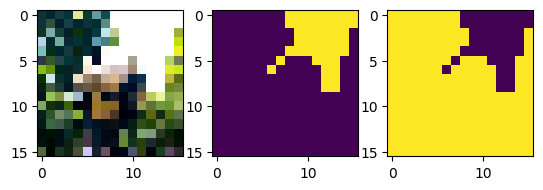

In [122]:
im, mask = val_dataset[1]

fig, axs = plt.subplots(1,3)
axs[0].imshow(hist_fix(im).permute((1,2,0)))
axs[1].imshow(mask) # Unknown region to generate
axs[2].imshow(~mask) # Known region

In [105]:
def prepare_loaders():
        
    device = torch.device('cuda' if torch.cuda.is_available() else None)  
    print(f"Model will run on {device}")
    
    dataloader = DataLoader(train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=6, 
                            #persistent_workers=True,
                            pin_memory=True,
                           )
    
    valdataloader = DataLoader(val_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False,
                               #persistent_workers=True,
                               num_workers=6,
                               pin_memory=True)

    return dataloader, valdataloader 

In [106]:
dataloader, valdataloader  = prepare_loaders()

Model will run on cuda


In [107]:
device = torch.device('cuda' if torch.cuda.is_available() else None)  
print(f"Model will run on {device}")

Model will run on cuda


In [108]:
import warnings
warnings.filterwarnings('ignore')

In [127]:
train(dataloader, 
      valdataloader,
      device=device, 
      T=500, 
      img_size=IM_SIZE, 
      channels=64, 
      batch_size=BATCH_SIZE, 
      pretrained=True, 
      metric='MSE',
      experiment_name='pretrained_lpips', 
      lr=0.0001,
      )

09:29:11 - INFO: Starting epoch 1:
  2%|█▏                                                     | 13/590 [00:12<10:03,  1.05s/it, loss_func=0.0141]Exception in thread Thread-56 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 51, in _pin_memory_loop
    do_one_step()
  File "/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/multiprocessing/queues.py", line 122, in 

KeyboardInterrupt: 

In [110]:
model = UNet(img_size=IM_SIZE, c_in=3, c_out=3, 
             time_dim=256,channels=64, device=device).to(device)
diffusion = Diffusion(img_size=IM_SIZE, T=500, beta_start=1e-4, beta_end=0.02, device=device)
ckpt = torch.load("models/pretrained_mse2/weights-30.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [111]:
def hist_fix(im):
    new_im = im.clone()
    
    new_im[0] = (im[0] - torch.min(im[0])) / (torch.max(im[0])-torch.min(im[0]))
    new_im[1] = (im[1] - torch.min(im[1])) / (torch.max(im[1])-torch.min(im[1]))
    new_im[2] = (im[2] - torch.min(im[2])) / (torch.max(im[2])-torch.min(im[2]))

    return new_im

In [123]:
img_name = test_images[1]
image = Image.open(img_name)

img = transform(image)

# Get mask
bright_transform = A.RandomBrightnessContrast(p=1, brightness_limit=(0.2,0.2), contrast_limit=(0.1,0.1)) # Contrast limit has to be set otherwise it fluctuates
bright_image = torch.from_numpy(bright_transform(image=img.numpy())['image'])
mask = torch.mean(bright_image,0) >= 255 / 255

reconstructed_image = hist_fix(bright_image)

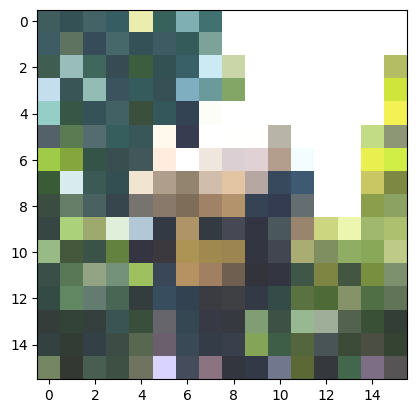

In [124]:
plt.imshow(bright_image.permute((1,2,0)))

In [125]:
sampled_image = diffusion.p_sample_loop(reconstructed_image.unsqueeze(0).to(device), mask.unsqueeze(0).to(device), model,  batch_size=1)

09:25:35 - INFO: Sampling 1 new images....
100%|████████████████████████████████████████████████████████████████████████| 499/499 [00:35<00:00, 14.20it/s]


09:26:11 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


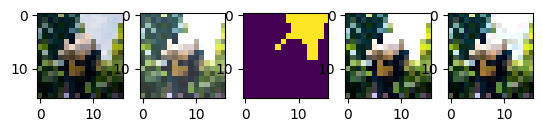

In [126]:
fig, axs = plt.subplots(1,5)
axs[0].imshow(img.permute((1,2,0)))
axs[1].imshow(bright_image.permute((1,2,0)))
axs[2].imshow(mask)
axs[3].imshow(reconstructed_image.permute((1,2,0)))
axs[4].imshow(sampled_image.squeeze(0).cpu().permute((1,2,0))) # Known region

In [99]:
sampled_image * 1.2

tensor([[[[166.8000, 162.0000, 199.2000, 171.6000, 187.2000, 184.8000, 189.6000,
           165.6000, 190.8000, 165.6000, 188.4000, 190.8000, 180.0000, 158.4000,
           159.6000, 162.0000],
          [159.6000, 194.4000, 176.4000, 150.0000, 229.2000, 152.4000, 170.4000,
           194.4000, 196.8000, 171.6000, 159.6000, 188.4000, 164.4000, 194.4000,
           166.8000, 162.0000],
          [267.6000, 230.4000, 234.0000, 163.2000, 224.4000, 205.2000, 163.2000,
           154.8000, 195.6000, 184.8000, 160.8000, 176.4000, 212.4000, 177.6000,
           182.4000, 160.8000],
          [266.4000, 285.6000, 302.4000, 276.0000, 240.0000, 218.4000, 216.0000,
           229.2000, 159.6000, 163.2000, 176.4000, 158.4000, 156.0000, 163.2000,
           184.8000, 187.2000],
          [255.6000, 289.2000, 286.8000, 297.6000, 306.0000, 306.0000, 214.8000,
           216.0000, 208.8000, 219.6000, 280.8000, 159.6000, 218.4000, 164.4000,
           156.0000, 194.4000],
          [301.2000, 295.2000,

In [ ]:
sampled_images = diffusion.p_sample_loop(images, masks, model,  batch_size=images.shape[0])

In [13]:
train(dataloader, 
      valdataloader,
      device=device, 
      T=500, 
      img_size=IM_SIZE, 
      channels=64, 
      batch_size=BATCH_SIZE, 
      pretrained=False, 
      metric='MSE',
      experiment_name='raw_mse2', 
      lr=0.001,
      )

08:32:36 - INFO: Starting epoch 1:
 14%|███████▋                                               | 82/590 [00:06<00:40, 12.69it/s, loss_func=0.0444]


KeyboardInterrupt: 

In [ ]:
len(val_images)

In [ ]:
dataloader, valdataloader  = prepare_loaders()

In [ ]:
train(dataloader, 
      valdataloader,
      device=device, 
      T=250, 
      img_size=IM_SIZE, 
      channels=64, 
      batch_size=BATCH_SIZE, 
      pretrained=False, 
      metric='mse',
      experiment_name='raw_mse')

In [ ]:
train(dataloader, 
      valdataloader,
      device=device, 
      T=250, 
      img_size=IM_SIZE, 
      channels=64, 
      batch_size=BATCH_SIZE, 
      pretrained=True, 
      metric='mse',
      experiment_name='pretrained_mse')

In [ ]:
(3535 / 6) *20 / 60 /60

In [ ]:
sdadas

In [ ]:
(~m.unsqueeze(1)).shape

In [ ]:
x_known = x * ~m.unsqueeze(1)
x_unknown = x * m.unsqueeze(1)

In [ ]:
img_known = np.einsum('xabc->bca', x_known)

In [ ]:
x.shape

In [ ]:
plt.imshow(np.einsum('abc->bca', x_unknown[1]))

In [ ]:
plt.imshow( np.einsum('abc->bca', x_known[1]))

# algo: 
## q-sample
* we do it normally, for full image
* after everything we apply masks to each of the noised image

## p sample 
* we take noised image and denoise it
* we apply masks and get values only for the maksed regions
* we then add corresponding noised image from the q sample with masks 

In [ ]:
set_seed(SEED)
im, mask = train_dataset[0]


# Apply the mask to all three channels of the image
result = im * mask.unsqueeze(0)
print(result[0,0,0])
plt.imshow(result.permute(1,2,0))
plt.show()